# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [3]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [1]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext

conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")
conf.set("spark.executor.instances", "2") # кол-во executor'ов
conf.set("spark.executor.cores", "3") # сколько ядер у каждого

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-02-04 11:36 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-04 11:36 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-04 11:36 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-04 11:36 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-04 11:36 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-02-04 11:36 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-04 11:36 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-04 11:36 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-04 11:36 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [88]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 37.7 ms, sys: 368 µs, total: 38.1 ms
Wall time: 1min 21s


162541

Сохраним датасет в память

In [12]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 30.2 ms, sys: 8.11 ms, total: 38.3 ms
Wall time: 2min 12s


162541

Количество фильмов

In [14]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [69]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [79]:
movies = movies \
    .map(lambda s: s.split(',')[:-1]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: (arr[0], ",".join(arr[1:])))\
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ('196959', 'I Am JFK Jr. (2016)'))),
 (180663, (5.0, ('180663', '"Goodbye, Boys! (1964)"'))),
 (147966, (5.0, ('147966', "Tarzan's Fight for Life (1958)"))),
 (131628, (5.0, ('131628', 'Loaded (2014)'))),
 (131922, (5.0, ('131922', 'Private Duty Nurses (1971)'))),
 (188573, (5.0, ('188573', 'Judy (2014)'))),
 (164787, (5.0, ('164787', 'You Cast A Spell On Me (2015)'))),
 (132321, (5.0, ('132321', 'Black Oak Conspiracy (1977)'))),
 (165221, (5.0, ('165221', 'Elf Bowling the Movie (2007)'))),
 (149268, (5.0, ('149268', 'The Pied Piper (1942)')))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [17]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [18]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-04 12:01 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-02-04 12:01 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [19]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [20]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [21]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

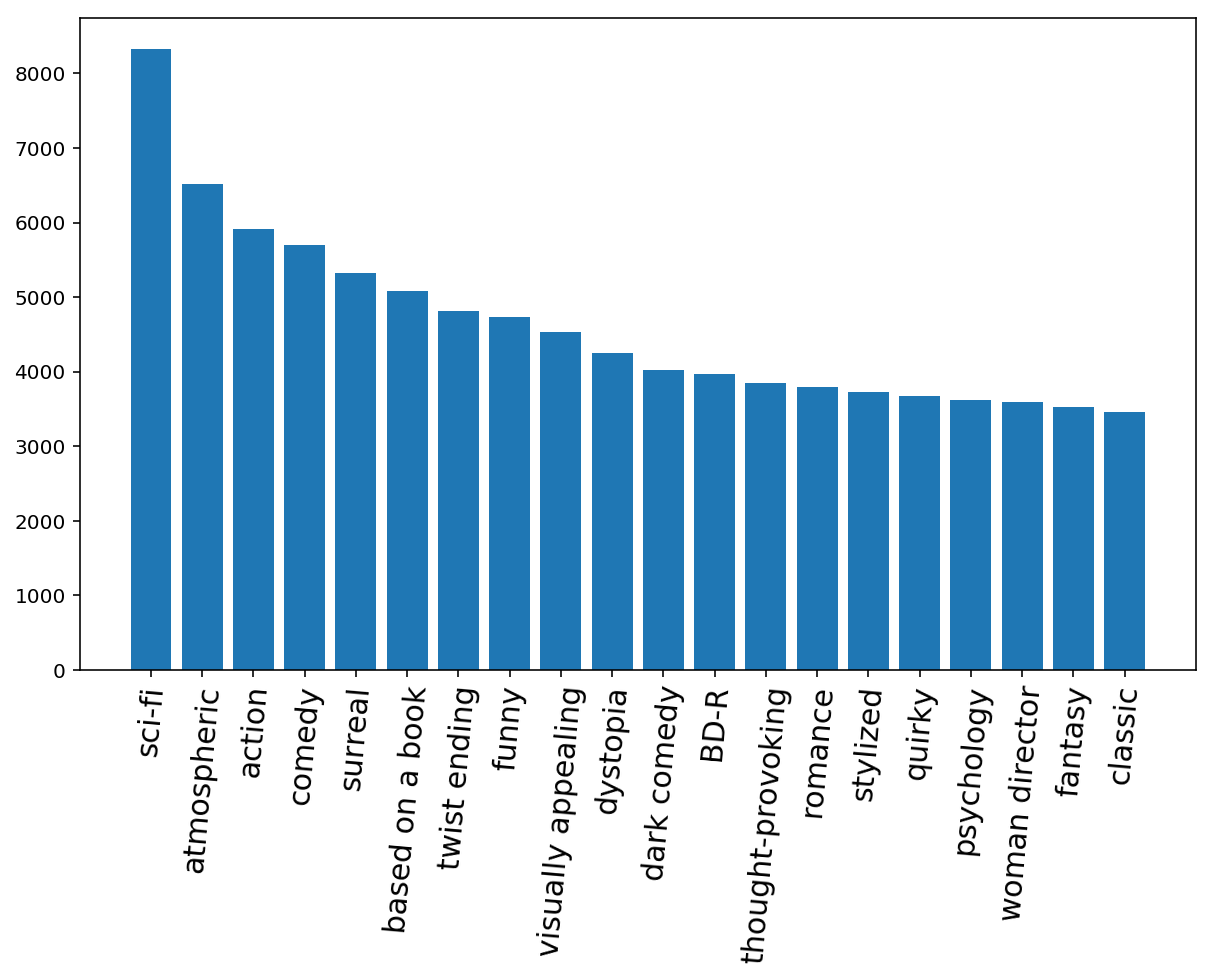

In [22]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [31]:
ratings_count = ratings.map(lambda r: (r.movie_id, 1)).reduceByKey(lambda a, b: a + b)
movies_most_ratings_ctn = ratings_count.join(movies).sortBy(lambda key_value: key_value[1][0], ascending=False).take(10)

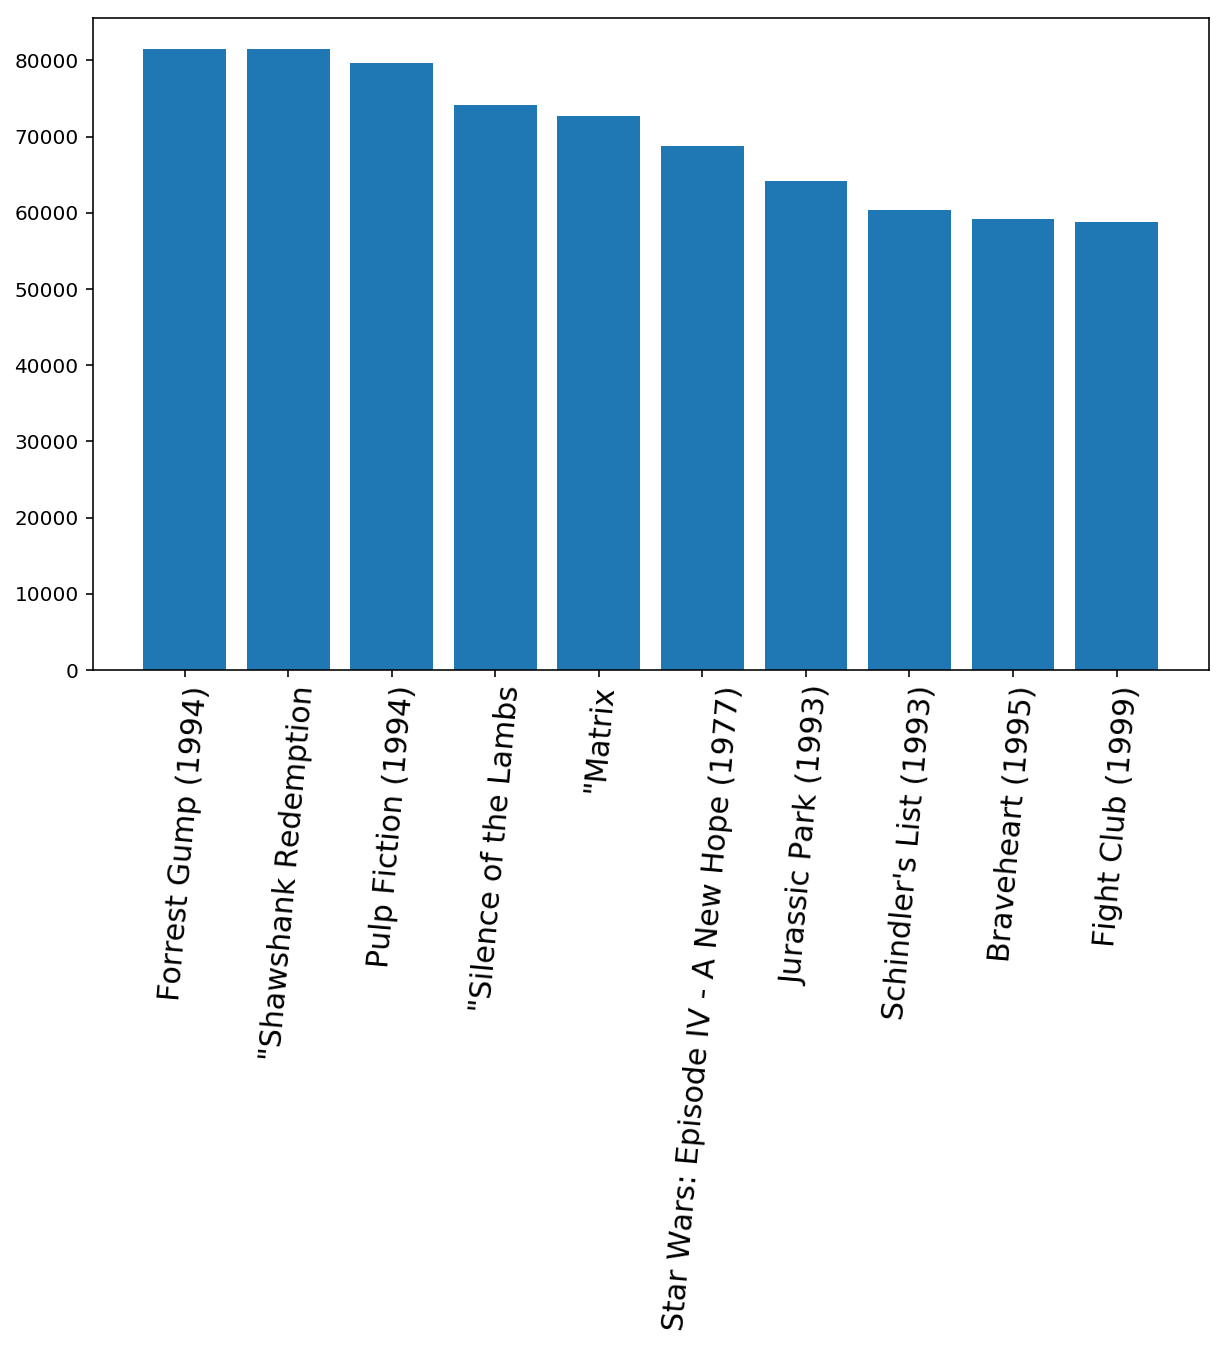

In [32]:
keys, values = zip(*[(tkn[1][1][1], tkn[1][0]) for tkn in movies_most_ratings_ctn])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

In [33]:
for k, v in zip(keys, values):
    print(v, "|", k)

81491 | Forrest Gump (1994)
81482 | "Shawshank Redemption
79672 | Pulp Fiction (1994)
74127 | "Silence of the Lambs
72674 | "Matrix
68717 | Star Wars: Episode IV - A New Hope (1977)
64144 | Jurassic Park (1993)
60411 | Schindler's List (1993)
59184 | Braveheart (1995)
58773 | Fight Club (1999)


### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [34]:
ratings_count = ratings.filter(lambda r: r.rating == 5).map(lambda r: (r.movie_id, 1)).reduceByKey(lambda a, b: a + b)
movies_most_ratings_ctn = ratings_count.join(movies).sortBy(lambda key_value: key_value[1][0], ascending=False).take(10)

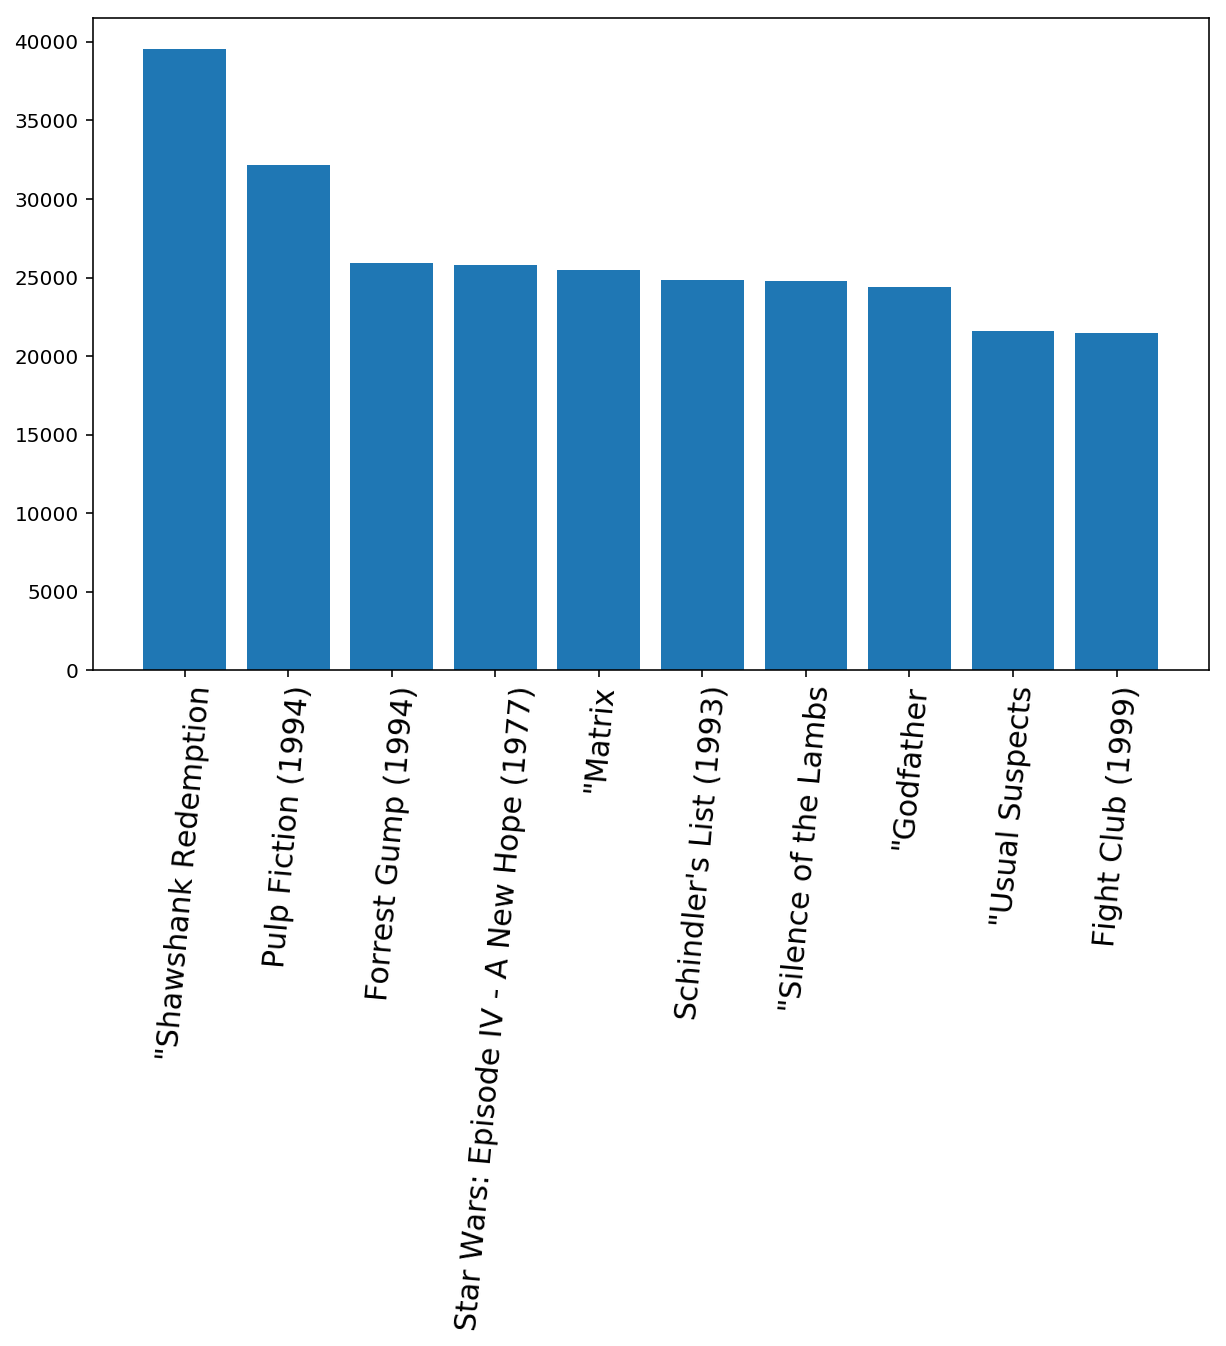

In [35]:
keys, values = zip(*[(tkn[1][1][1], tkn[1][0]) for tkn in movies_most_ratings_ctn])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

In [36]:
for k, v in zip(keys, values):
    print(v, "|", k)

39553 | "Shawshank Redemption
32169 | Pulp Fiction (1994)
25918 | Forrest Gump (1994)
25804 | Star Wars: Episode IV - A New Hope (1977)
25482 | "Matrix
24853 | Schindler's List (1993)
24801 | "Silence of the Lambs
24418 | "Godfather
21585 | "Usual Suspects
21486 | Fight Club (1999)


### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [46]:
div_const = 5

rating_hist = ratings.map(lambda r: (r.movie_id, (r.rating, 1))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
              .mapValues(lambda ratings: int(div_const * ratings[0] / ratings[1])).map(lambda r: (r[1], 1)).reduceByKey(lambda a, b: a + b)\
              .collect()

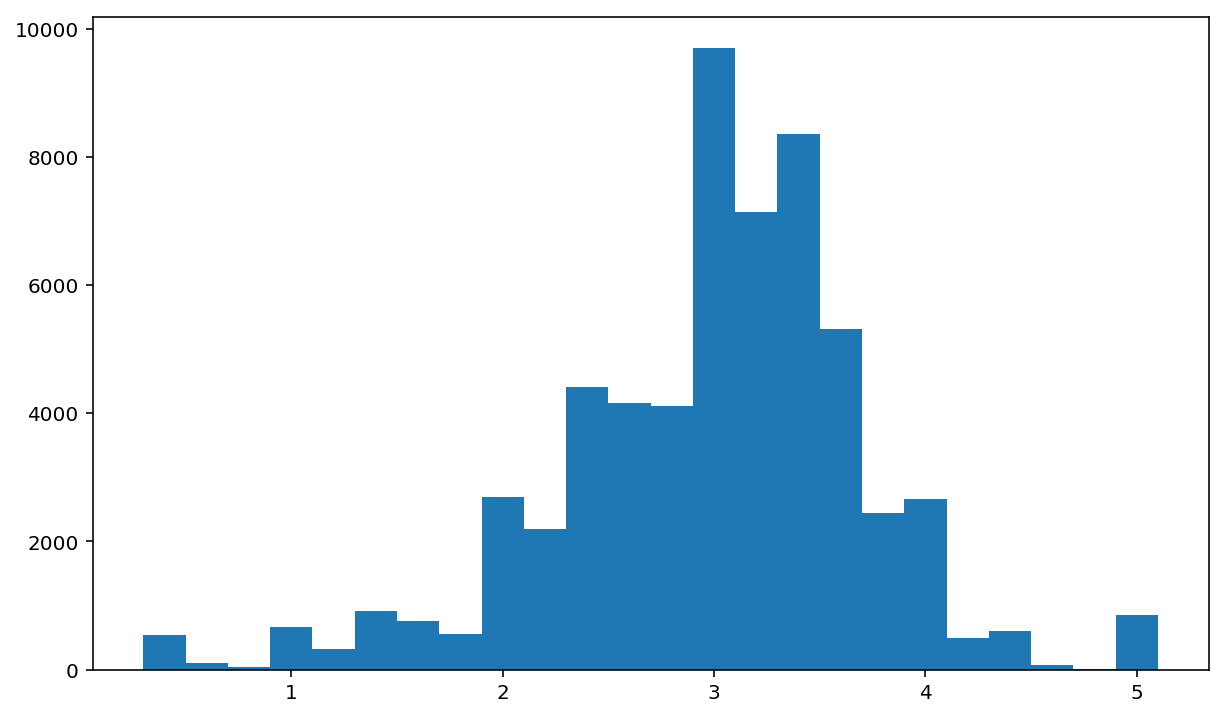

In [48]:
keys, values = zip(*[(rate/div_const, count) for rate, count in rating_hist])

f, ax = plt.subplots(figsize=(10, 6))
plt.bar(keys, values, align="center", width=1/div_const)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [51]:
div_const = 1000

rating_ctn_hist = ratings.map(lambda r: (r.movie_id, 1)).reduceByKey(lambda a, b: a + b).map(lambda r: (r[1] // div_const , 1)).reduceByKey(lambda a, b: a + b).collect()

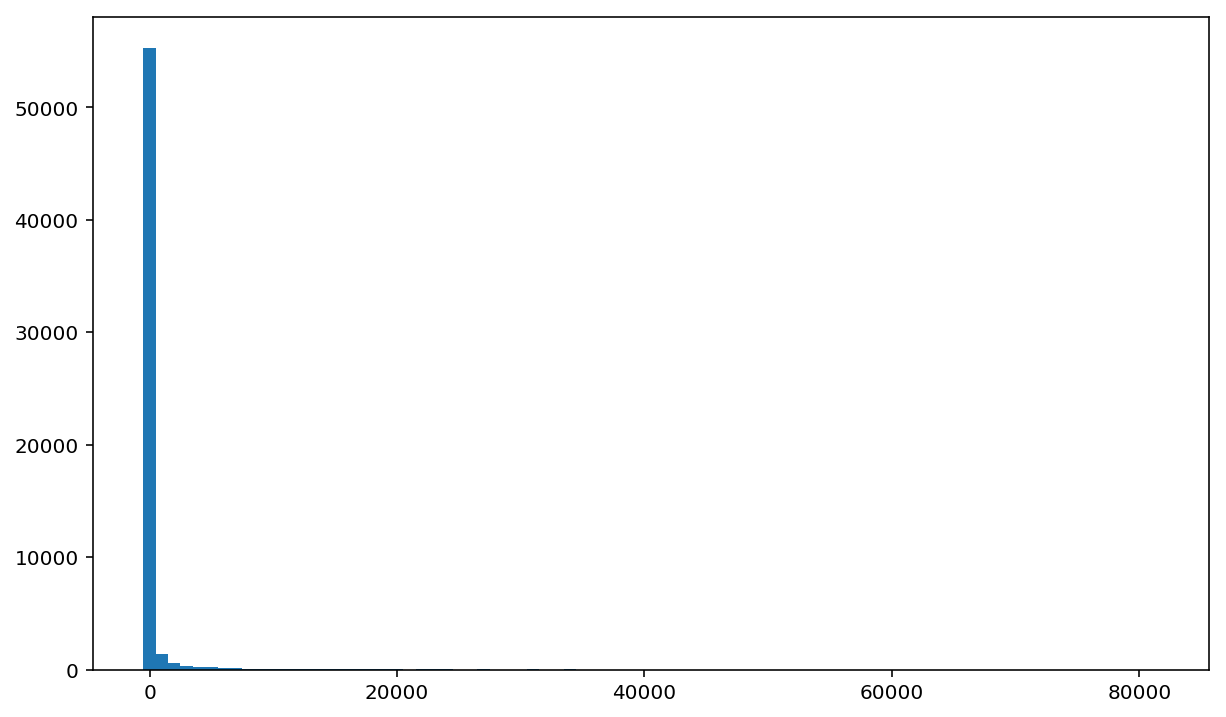

In [52]:
keys, values = zip(*[(div_const * rate, count) for rate, count in rating_ctn_hist])

f, ax = plt.subplots(figsize=(10, 6))
plt.bar(keys, values, align="center", width=div_const)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [66]:
mvs = sc.textFile(MOVIES_PATH)

In [80]:
genres = mvs.map(lambda s: s.split(',')).filter(lambda row: row[0].isdigit())\
         .flatMap(lambda row: row[-1].split('|')).filter(lambda row: row[0] != '(no genres listed)')\
         .map(lambda genre: (genre, 1)).reduceByKey(lambda a, b: a + b).collect()

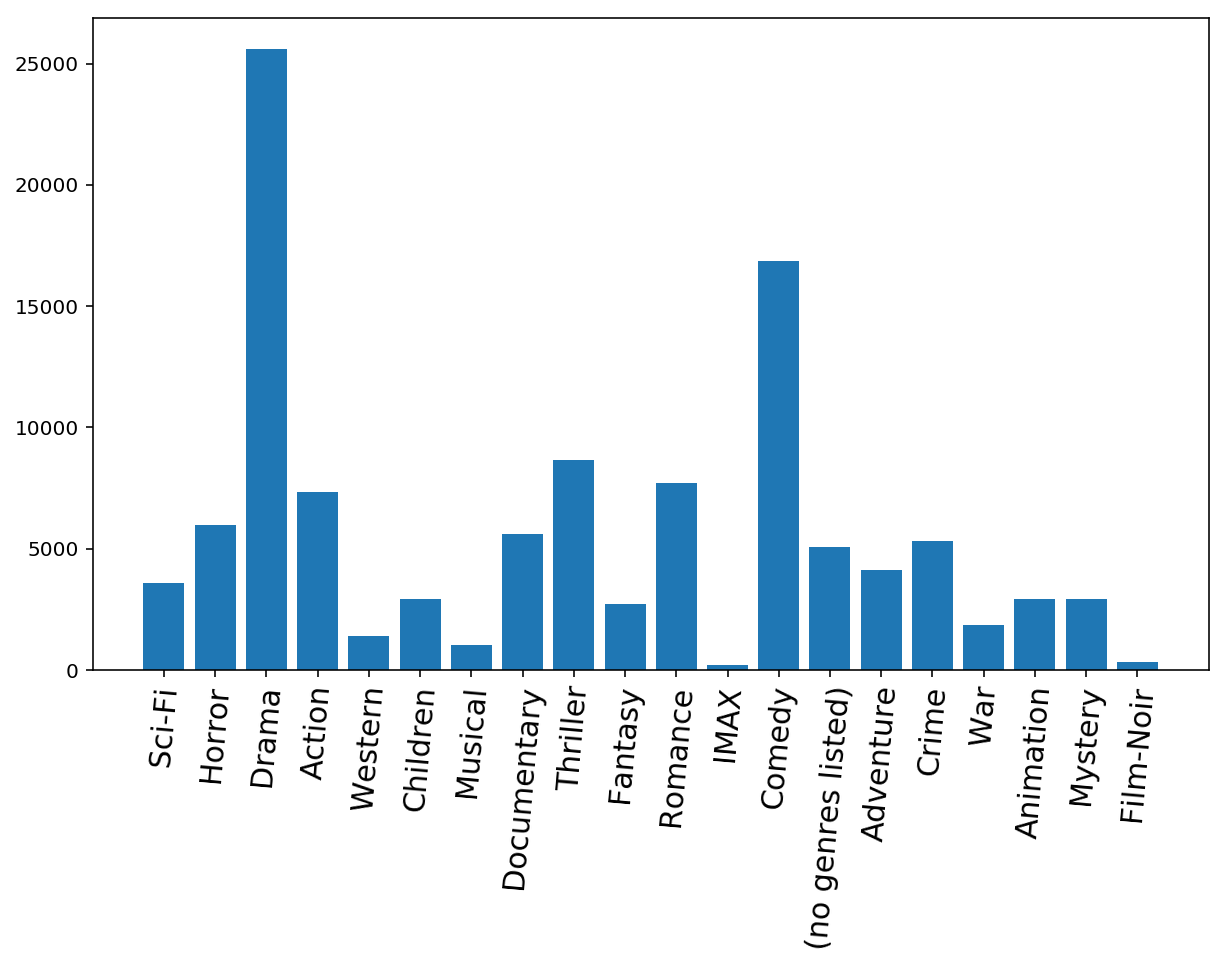

In [84]:
keys, values = zip(*genres)

f, ax = plt.subplots(figsize=(10, 6))
plt.bar(keys, values, align="center")
plt.xticks(rotation=85, fontsize=15)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [111]:
import json

tmdb = sc.textFile(TMDB_PATH)
casts = tmdb \
    .map(lambda row: json.loads(row))\
    .filter(lambda row: 'title' in row)\
    .map(lambda row: (row["id"], row["title"], row["casts"]["cast"]))\
    .flatMap(lambda row: [(cast, row[0], row[1]) for cast in row[2]])

tmdb = tmdb \
    .map(lambda row: json.loads(row))\
    .filter(lambda row: 'title' in row)\
    .keyBy(lambda row: int(row['id']))

In [159]:
tmdb.take(1)

[(862,
  {'adult': False,
   'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
   'belongs_to_collection': {'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg',
    'id': 10194,
    'name': 'Toy Story Collection',
    'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg'},
   'budget': 30000000,
   'casts': {'cast': [{'cast_id': 14,
      'character': 'Woody (voice)',
      'credit_id': '52fe4284c3a36847f8024f95',
      'gender': 2,
      'id': 31,
      'name': 'Tom Hanks',
      'order': 0,
      'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
     {'cast_id': 15,
      'character': 'Buzz Lightyear (voice)',
      'credit_id': '52fe4284c3a36847f8024f99',
      'gender': 2,
      'id': 12898,
      'name': 'Tim Allen',
      'order': 1,
      'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
     {'cast_id': 16,
      'character': 'Mr. Potato Head (voice)',
      'credit_id': '52fe4284c3a36847f8024f9d',
      'gender': 2,
      'id': 7167,
      'name': 'Don Rickles',
      'or

In [105]:
tom_hanks_films = casts.filter(lambda row: row[0]["id"] == 31).map(lambda row: row[2]).collect()

In [106]:
tom_hanks_films

['Toy Story',
 'Apollo 13',
 'Forrest Gump',
 'Philadelphia',
 'Sleepless in Seattle',
 'The Celluloid Closet',
 'That Thing You Do!',
 'Saving Private Ryan',
 "The 'Burbs",
 'Splash',
 'The Money Pit',
 'Nothing in Common',
 "You've Got Mail",
 'Big',
 'Return with Honor',
 'Toy Story 2',
 'The Bonfire of the Vanities',
 'The Green Mile',
 'A League of Their Own',
 'Volunteers',
 'Bachelor Party',
 'Punchline',
 'Cast Away',
 'Turner & Hooch',
 "He Knows You're Alone",
 'Joe Versus the Volcano',
 'Road to Perdition',
 'Catch Me If You Can',
 'Radio Flyer',
 'Dragnet',
 'The Ladykillers',
 'The Terminal',
 'The Man with One Red Shoe',
 'The Polar Express',
 'The Da Vinci Code',
 'Cars',
 'The Simpsons Movie',
 "Charlie Wilson's War",
 'The Great Buck Howard',
 'Angels & Demons',
 'Shooting War',
 'Toy Story 3',
 'The Pixar Story',
 'Larry Crowne',
 'Extremely Loud & Incredibly Close',
 'Beyond All Boundaries',
 'Cloud Atlas',
 'Captain Phillips',
 'Toy Story of Terror!',
 'Saving Mr. B

In [108]:
casts_counts = casts.map(lambda r: (int(r[0]["id"]), (r[0]["name"], 1))).reduceByKey(lambda a, b: (a[0], a[1] + b[1]))\
               .sortBy(lambda key_value: key_value[1][1], ascending=False).take(10)

In [110]:
for _, (name, count) in casts_counts:
    print(count, "|", name)

380 | Bess Flowers
184 | Frank Welker
175 | Christopher Lee
158 | Clarence Nash
152 | Irving Bacon
146 | John Carradine
142 | John Wayne
140 | Mel Blanc
134 | Samuel L. Jackson
130 | Eric Roberts


### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [123]:
links = sc.textFile(LINKS_PATH)
print(links.take(2))
links = links \
    .map(lambda s: s.split(','))\
    .filter(lambda arr: arr[0].isdigit() and arr[1].isdigit() and arr[2].isdigit())\
    .map(lambda row: [int(r) for r in row])

['movieId,imdbId,tmdbId', '1,0114709,862']


In [134]:
years = tmdb.map(lambda row: (row[0], row[1]["release_date"].split("-")[0])).filter(lambda row: row[1].isdigit()).map(lambda row: (row[0], int(row[1])))
movie2year = years.join(links.map(lambda r: (r[2], r[0]))).map(lambda row: (row[1][1], row[1][0]))

In [148]:
gy = mvs.map(lambda s: s.split(',')).filter(lambda row: row[0].isdigit()).map(lambda row: (int(row[0]), row[-1].split('|')))\
     .join(movie2year).flatMap(lambda row: [((genre, row[1][1]), 1) for genre in row[1][0]])\
     .filter(lambda row: row[0][0] != '(no genres listed)').reduceByKey(lambda a, b: a + b)

In [149]:
genre2year2count = gy.collect()

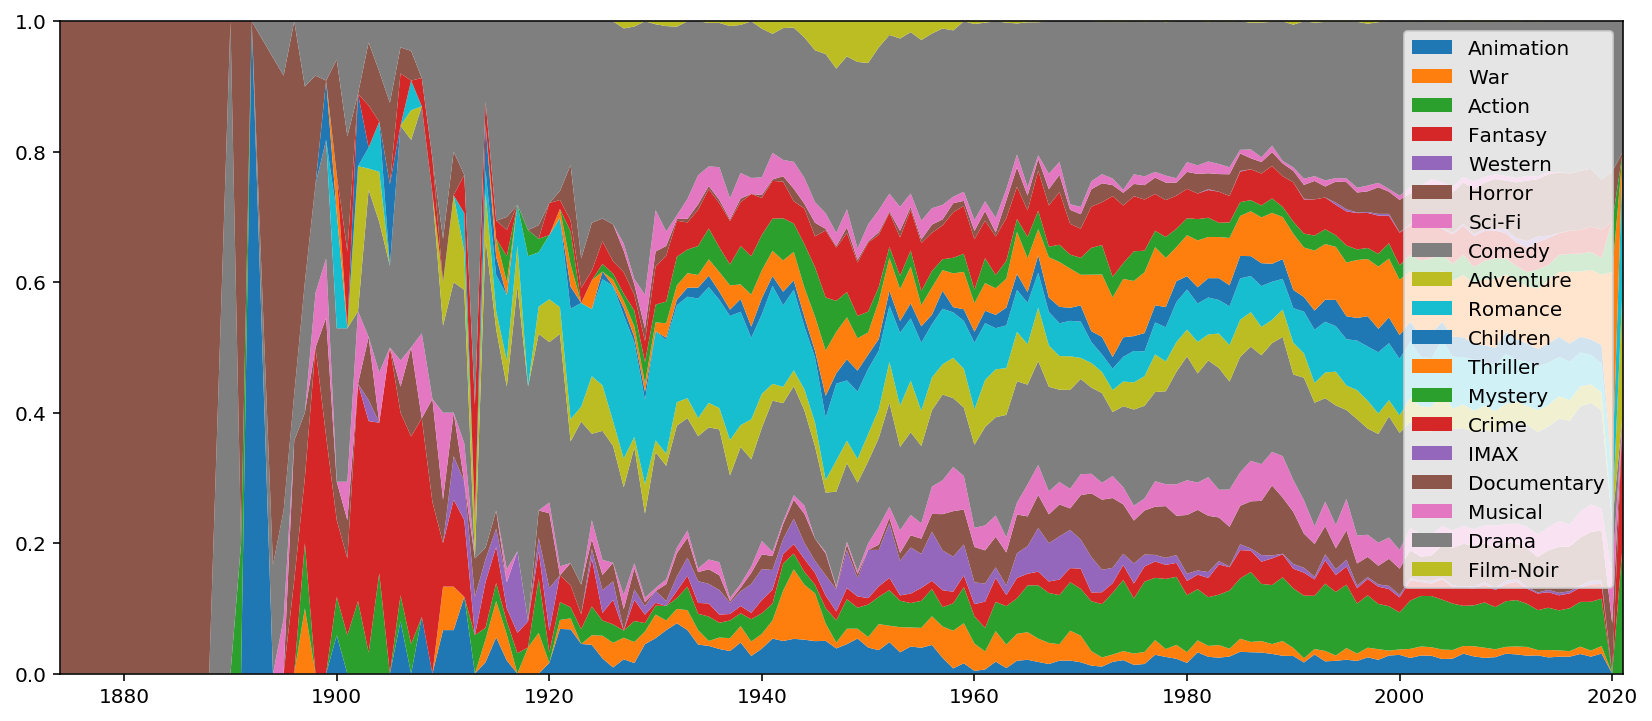

In [156]:
import numpy as np
unique_years = list(np.unique([y for (_, y), _ in genre2year2count]))
unique_years.sort()
unique_genres = set([g for (g, _), _ in genre2year2count])
y2id = dict([(y, i) for i, y in enumerate(unique_years)])
g2y2c = dict([(g, np.zeros(len(unique_years))) for g in unique_genres])
y2c = np.zeros(len(unique_years))

for (g, y), c in genre2year2count:
    g2y2c[g][y2id[y]] = c
    y2c[y2id[y]] += c

f, ax = plt.subplots(figsize=(14, 6))
plt.stackplot(unique_years, [g2y2c[g] / y2c for g in g2y2c], labels=list(g2y2c.keys()))
plt.xlim(unique_years[0], unique_years[-1])
plt.ylim(0, 1)
plt.legend()
plt.show()

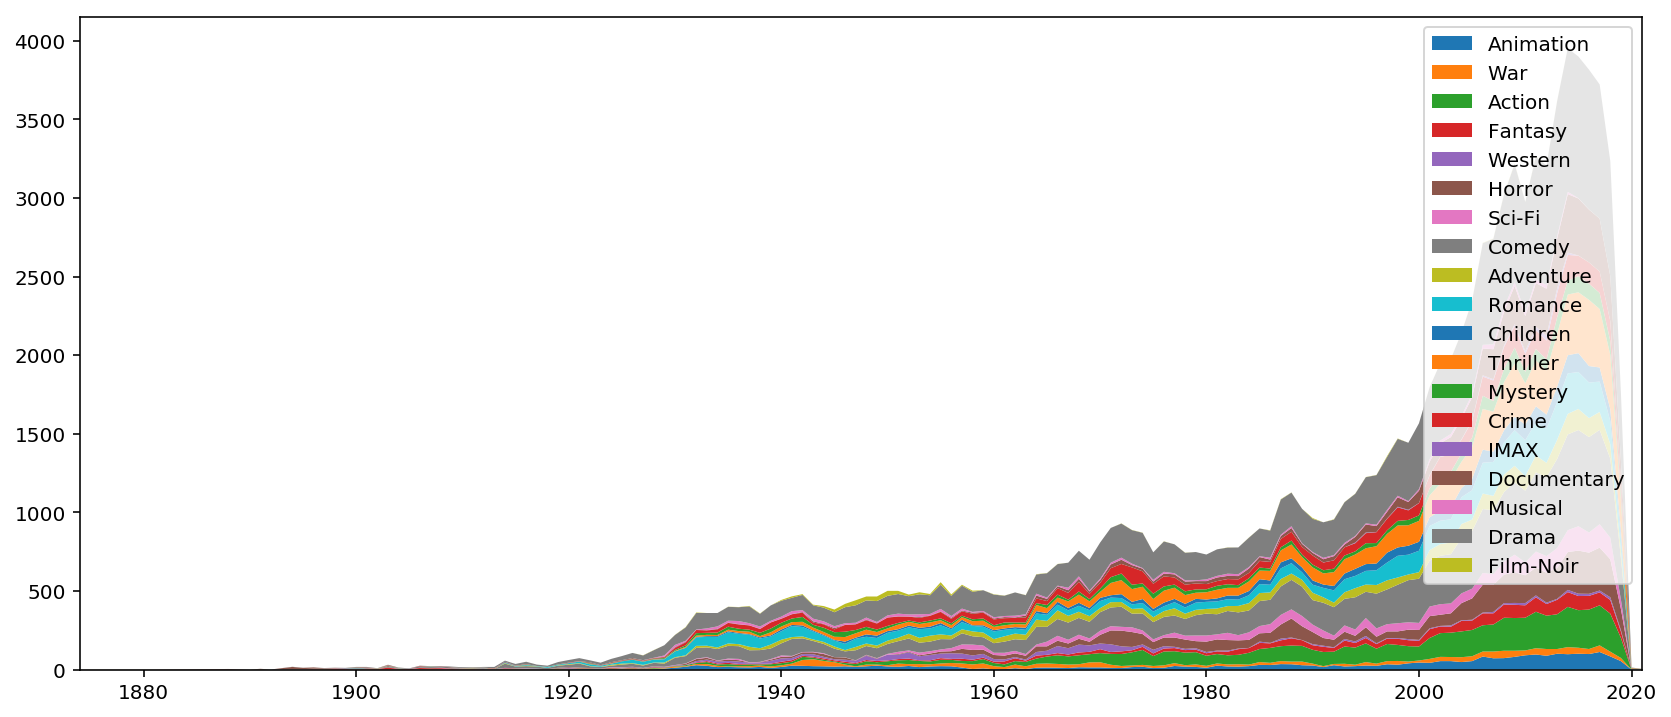

In [158]:
# Кажется, так немного лучше
f, ax = plt.subplots(figsize=(14, 6))
plt.stackplot(unique_years, [g2y2c[g] for g in g2y2c], labels=list(g2y2c.keys()))
plt.xlim(unique_years[0], unique_years[-1])
plt.legend()
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [166]:
roi = tmdb.map(lambda row: (row[0], (row[1]["revenue"], row[1]["budget"])))
movie2roi = roi.join(links.map(lambda r: (r[2], r[0]))).map(lambda row: (row[1][1], row[1][0]))

In [173]:
gy = mvs.map(lambda s: s.split(',')).filter(lambda row: row[0].isdigit()).map(lambda row: (int(row[0]), row[-1].split('|')))\
     .join(movie2roi).flatMap(lambda row: [(genre, np.array(row[1][1])) for genre in row[1][0]])\
     .filter(lambda row: row[0] != '(no genres listed)').reduceByKey(lambda a, b: a + b).mapValues(lambda a: a[0]/a[1] if a[1] > 0 else 0)

In [174]:
g2roi = gy.collect()

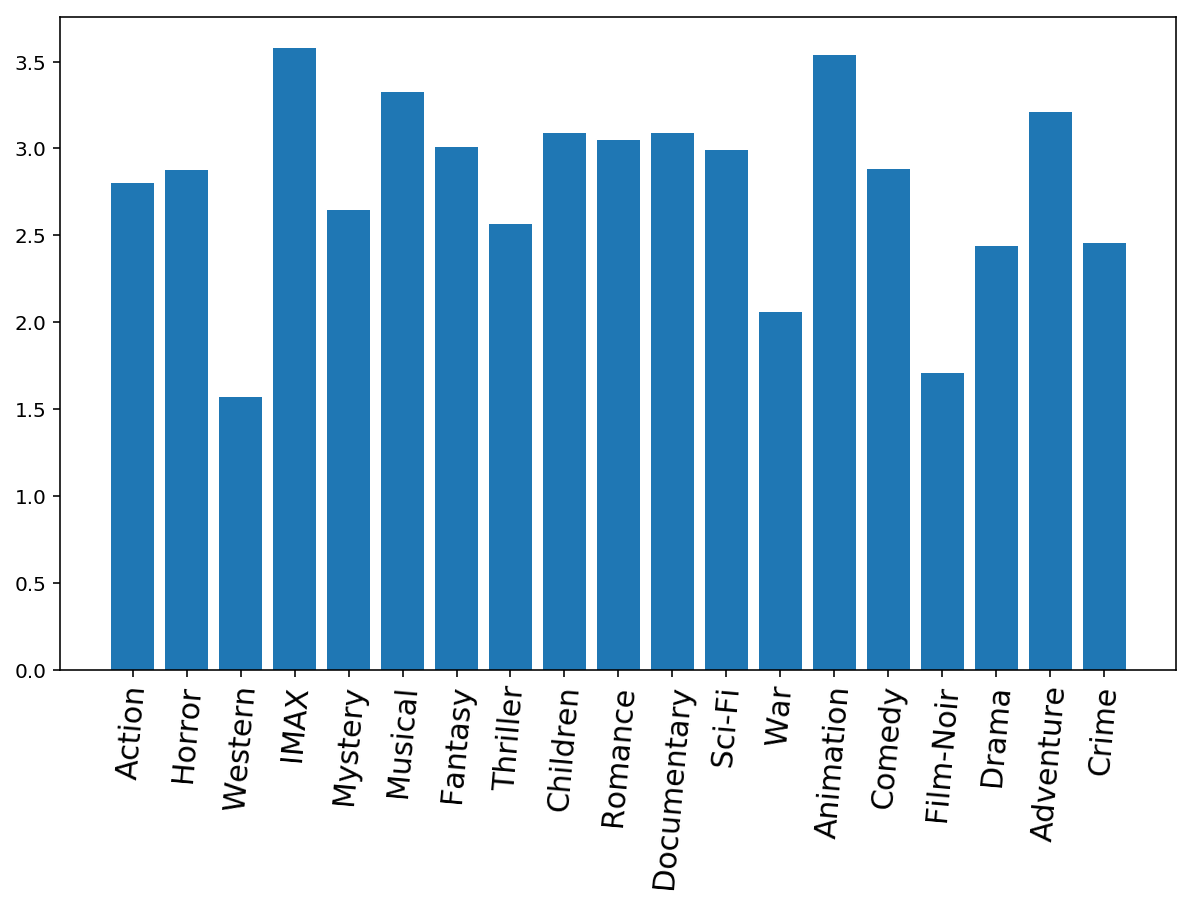

In [176]:
keys, values = zip(*g2roi)

f, ax = plt.subplots(figsize=(10, 6))
plt.bar(keys, values, align="center")
plt.xticks(rotation=85, fontsize=15)
plt.show()